In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iterativeClustering import clusterings_with_hors
from cluster import build_seqs_distance_matrix, distance_values
from Bio import SeqIO
from Bio import Phylo
from showHOR import show_hor, show_hors, show_hor_tree
from featureUtils import BED_file_to_features, feature_to_seq
from phylogeny_sorting import sort_phylogeny_by_leaf_names


In [2]:
references = {seq.id : seq for seq in SeqIO.parse("./data/monomers/chr2_centromere_plus2Mb.fasta", "fasta")}

In [3]:
monomers_as_features = BED_file_to_features("./data/monomers/chr2_StringDecMon2extr_noMorgante.bed")

In [4]:
monomers_as_features[0]

SeqFeature(SimpleLocation(ExactPosition(1916940), ExactPosition(1917047), strand=-1, ref='chr2:10940332-15983263'), type='repeat', id='chr2:12857272-12857379', ref='chr2:10940332-15983263')

In [5]:
[(feature.location.start, feature.__len__()) for feature in monomers_as_features if feature.__len__() < 70]

[(ExactPosition(1985104), 60),
 (ExactPosition(2373213), 58),
 (ExactPosition(2380415), 59),
 (ExactPosition(2482806), 60),
 (ExactPosition(2488408), 60),
 (ExactPosition(2723085), 60),
 (ExactPosition(2746370), 68),
 (ExactPosition(3014699), 55)]

In [6]:
# sample monomers for testing purposes (comment out for complete analysis)

# sample_size = 60
# num_samples = 5

# sample_page = len(monomers_as_features) // num_samples
# sample_offset = (sample_page - sample_size) // 2

# def slice_seq(seq, position, length):
#     return seq[position : position + length]

# monomers_as_features = [
#     monomer
#     for sample_index in range(num_samples)
#     for monomer in slice_seq(monomers_as_features, sample_index * sample_page + sample_offset, sample_size)
# ]

In [7]:
monomers_as_seqs = [feature_to_seq(feature, references) for feature in monomers_as_features]

In [8]:
monomer_dists = build_seqs_distance_matrix(monomers_as_seqs)

In [9]:
def max_len(strings):
    return max([len(s) for s in strings])

(array([2.186400e+04, 3.680900e+04, 4.914200e+04, 6.673100e+04,
        8.968700e+04, 1.180140e+05, 1.502440e+05, 1.881710e+05,
        2.409830e+05, 3.039120e+05, 3.703790e+05, 4.451380e+05,
        5.183620e+05, 5.891260e+05, 6.418740e+05, 6.806570e+05,
        6.685190e+05, 6.367270e+05, 5.662620e+05, 4.858900e+05,
        4.007310e+05, 3.190660e+05, 2.467160e+05, 1.897630e+05,
        1.521990e+05, 1.253520e+05, 1.215620e+05, 1.374230e+05,
        1.755000e+05, 2.287040e+05, 2.800760e+05, 3.241400e+05,
        3.584810e+05, 3.926610e+05, 4.069210e+05, 4.368090e+05,
        5.208560e+05, 7.332940e+05, 1.036467e+06, 1.350784e+06,
        1.588932e+06, 1.662870e+06, 1.567971e+06, 1.371135e+06,
        1.100390e+06, 8.425870e+05, 6.225740e+05, 4.614420e+05,
        3.224860e+05, 2.164030e+05, 1.535340e+05, 1.064860e+05,
        7.475100e+04, 5.393300e+04, 4.166100e+04, 3.750600e+04,
        3.859000e+04, 4.003300e+04, 3.826300e+04, 3.338300e+04,
        2.443200e+04, 1.623800e+04, 8.96

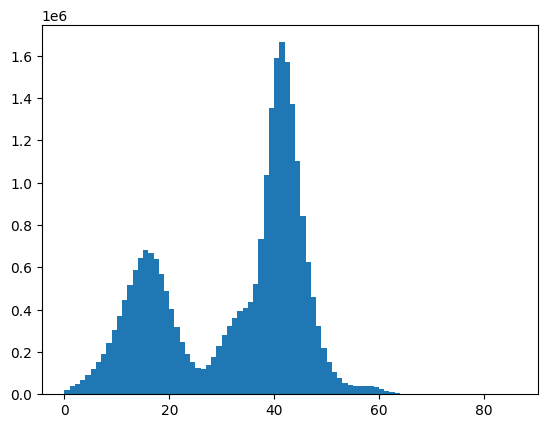

In [10]:
dist_values = distance_values(monomer_dists)
plt.hist(dist_values, bins=int(max(dist_values)))


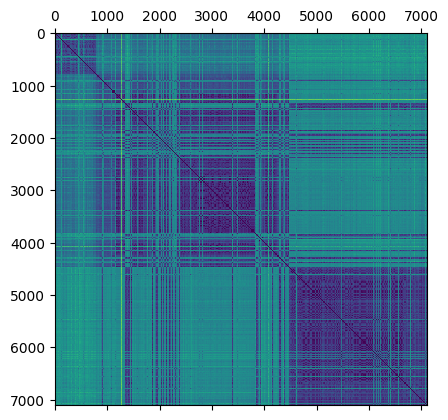

In [11]:
plt.matshow(monomer_dists)

In [12]:
phyloXml, hor_tree_root, clusterings = clusterings_with_hors(monomer_seqs=monomers_as_seqs, monomers_as_features=monomers_as_features, distance_matrix=monomer_dists, min_len_loop=1, min_loop_reps=5, max_len_loop=1000)

Start of clusterings_with_hors
Reorder
Reorder all
Indexes built, now reordering lists...
Lists reordered, now reordering matrix...
Matrix reordered
merge_clusters with distance as (7107, 7107), clusters as (), and max distance 0
adjacency matrix sparsity is 0.9989935546515267
merge_clusters with distance as (3885, 3885), clusters as (3885, 7107), and max distance 1
adjacency matrix sparsity is 0.9996061146640297
merge_clusters with distance as (2908, 2908), clusters as (2908, 7107), and max distance 2
adjacency matrix sparsity is 0.9995135082464728
merge_clusters with distance as (2373, 2373), clusters as (2373, 7107), and max distance 3
adjacency matrix sparsity is 0.9994091770939717
merge_clusters with distance as (1910, 1910), clusters as (1910, 7107), and max distance 4
adjacency matrix sparsity is 0.9992132891093994
Looking for loops in Num clusters: 1475, Seqs: ['A', 'BCDEFGH', 'IJKLMNOPQRSTUVWXYZabcYZabcYZabdeZafgYZabcYZahgiZajcYkabclZamcnZaogpqrstuvwxyz************************

/Users/miguel/git/dna-repeat-discovery/env/lib/python3.11/site-packages/Bio/Phylo/PhyloXML.py:985: PhyloXMLWarning: String monomer_clade_seq doesn't match the given regexp
  _check_str(ref, self.re_ref.match)


In [13]:
[
    [str(loop)
    for loop in clustering.loops]
    for clustering in clusterings
]

[['******** in [2041:2107],[2187:2228]#1,[2723:2764]#1',
  '****** in [3380:3415]'],
 ['******** in [2041:2109],[2187:2230]#1,[2723:2766]#1',
  '****** in [3379:3418]#2,[3451:3483]',
  '* in [324:329],[337:342],[399:404],[417:422],[625:634],[635:643],[644:650],[665:675],[676:687],[688:710],[711:722],[723:741],[752:760],[795:801],[815:823],[845:852],[856:867],[881:889],[893:906],[937:942],[1186:1192],[1607:1612],[1636:1644],[1651:1656],[1663:1668],[1669:1674],[1711:1720],[1725:1731],[1743:1752],[1757:1763],[1889:1900],[1901:1906],[1907:1914],[1915:1921],[1927:1932],[1942:1949],[1950:1957],[1960:1966],[1967:1974],[1983:1990],[1991:1998],[2001:2007],[2008:2015],[2017:2026],[2027:2037],[2038:2041],[2112:2118],[2130:2136],[2148:2157],[2165:2171],[2172:2179],[2233:2239],[2240:2250],[2258:2264],[2277:2286],[2294:2300],[2313:2319],[2320:2327],[2330:2336],[2337:2344],[2345:2352],[2355:2361],[2364:2373],[2374:2381],[2382:2389],[2390:2397],[2398:2404],[2410:2422],[2423:2435],[2436:2443],[2444:245

In [14]:
[
    str(clustering)
    for clustering in clusterings
]

["Num clusters: 1475, Seqs: ['A', 'BCDEFGH', 'IJKLMNOPQRSTUVWXYZabcYZabcYZabdeZafgYZabcYZahgiZajcYkabclZamcnZaogpqrstuvwxyz*************************************************************************************************************************************************************************', '***', '**', '**', '*', '*****', '**********************************************', '***********************************************', '***********************************************', '********************************************************************', '**', '******', '*', '**********************************************************************************************************************************************************************', '********************************************************************************************************************************************************************************************', '****************************************************************

In [15]:
phylogeny = phyloXml.phylogenies[0]

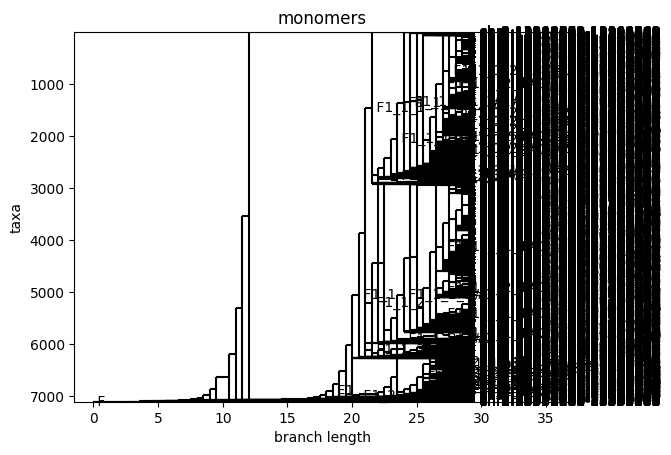

In [16]:
Phylo.draw(phylogeny)

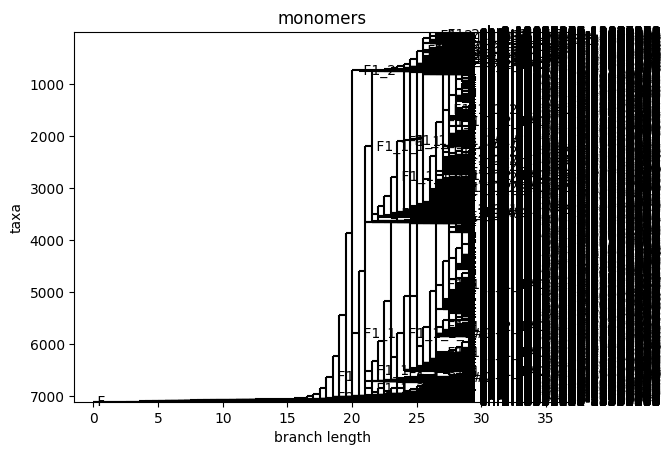

In [17]:
sort_phylogeny_by_leaf_names(phylogeny)
Phylo.draw(phylogeny)

Subtree: []
None


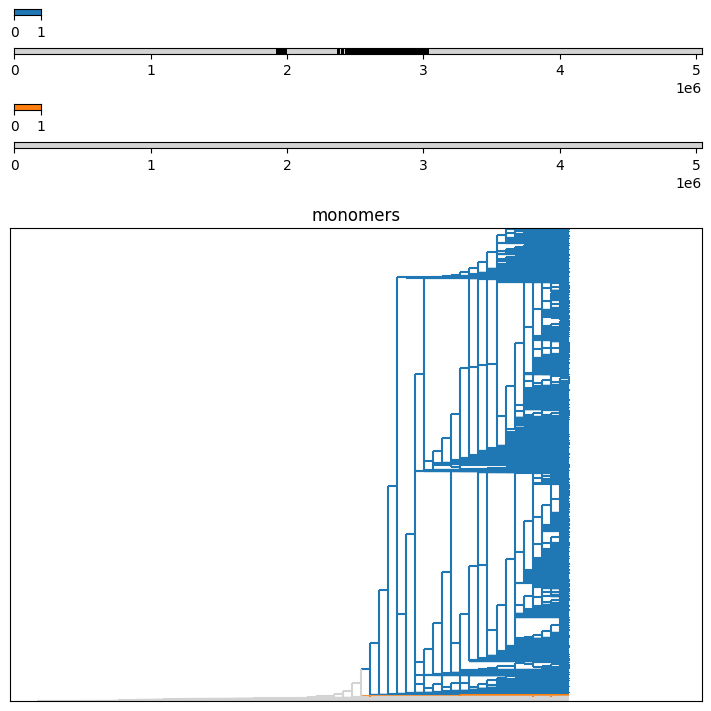

Subtree: [1]
None


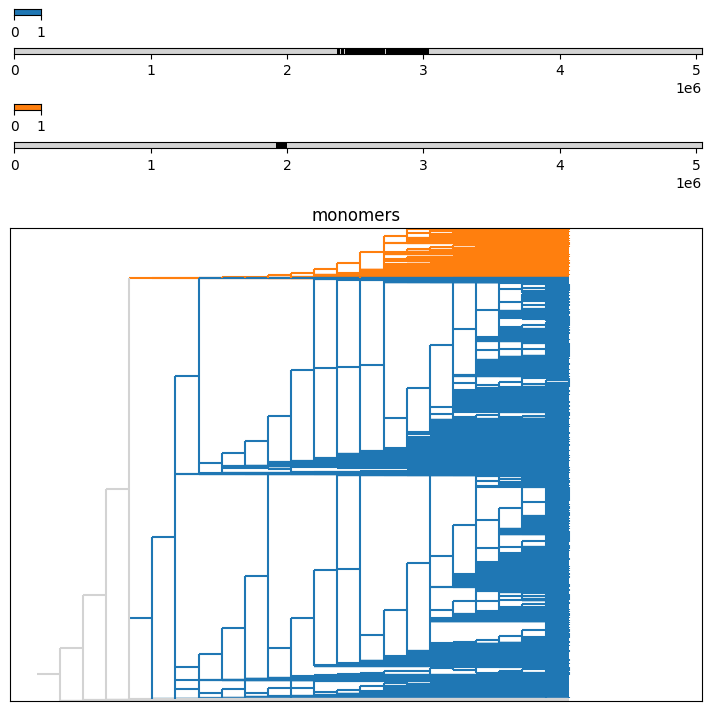

Subtree: [1, 1]
None


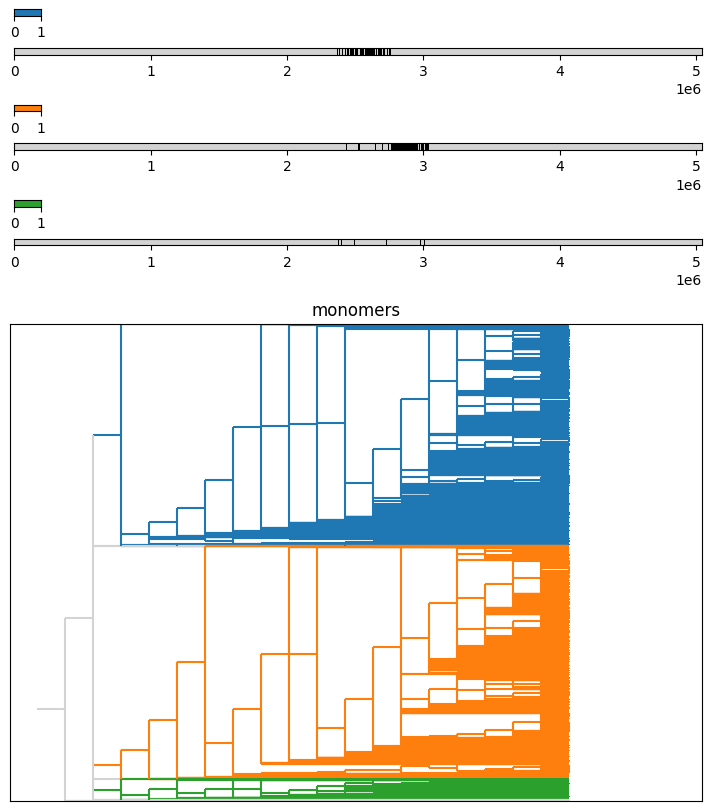

Subtree: [1, 1, 1]
None


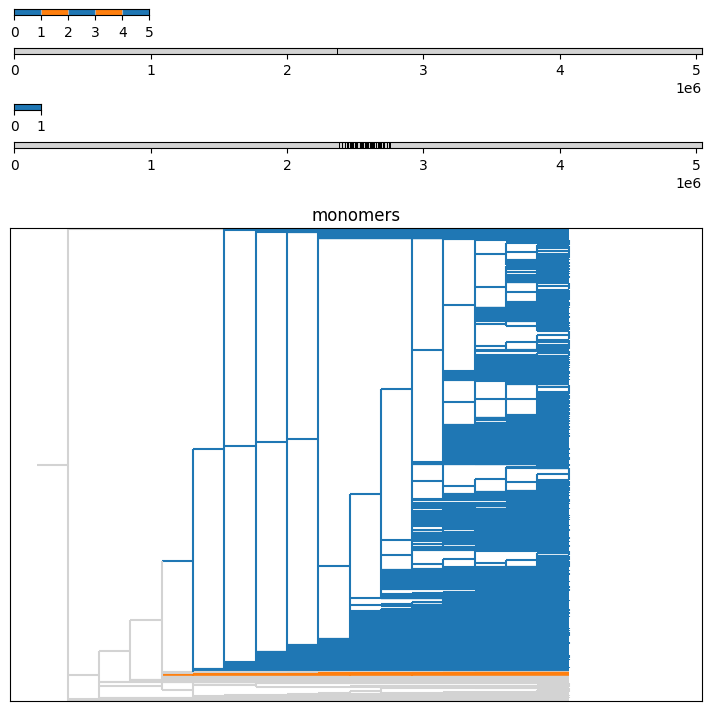

Subtree: [1, 1, 1, 1]
None


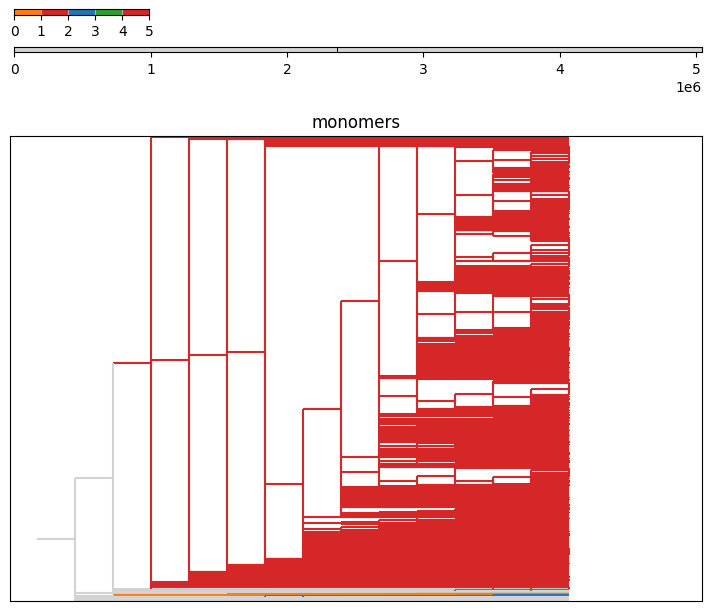

Subtree: [1, 1, 1, 1, 1]
None


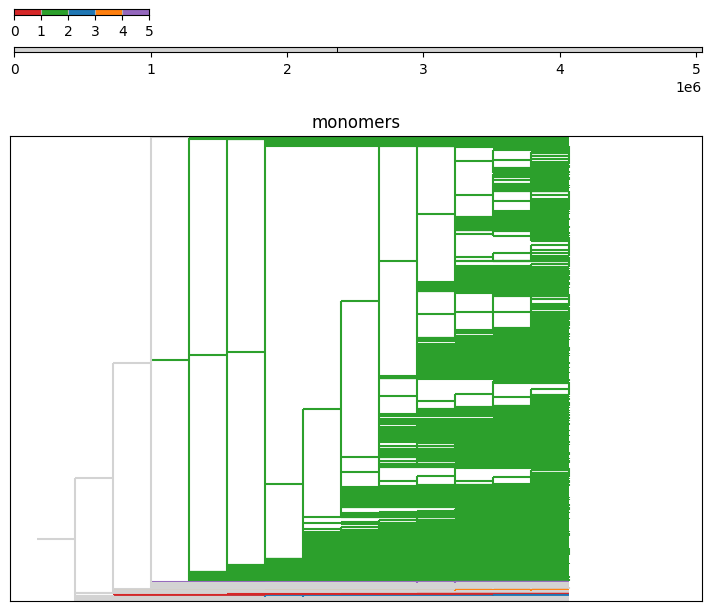

Subtree: [1, 1, 1, 2]
None


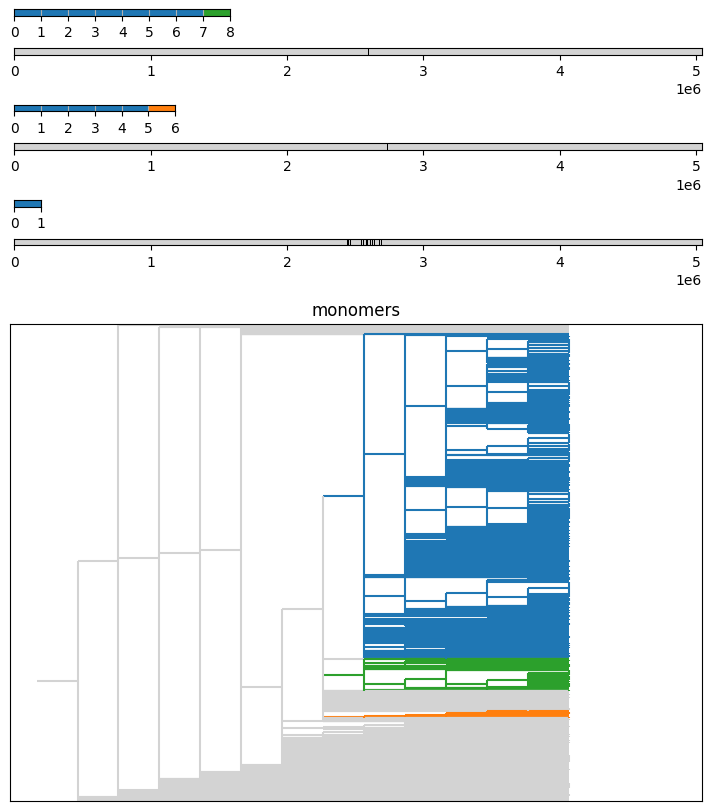

Subtree: [1, 1, 1, 2, 1]
None


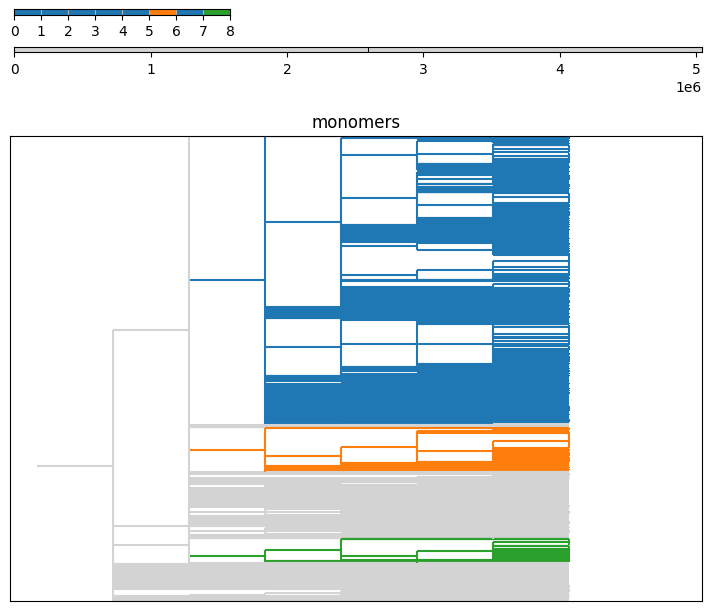

Subtree: [1, 1, 1, 2, 2]
None


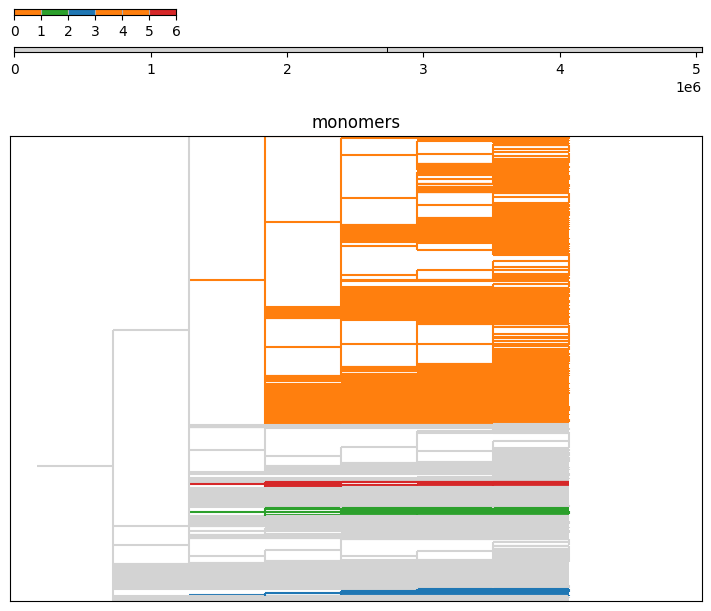

Subtree: [1, 1, 2]
None


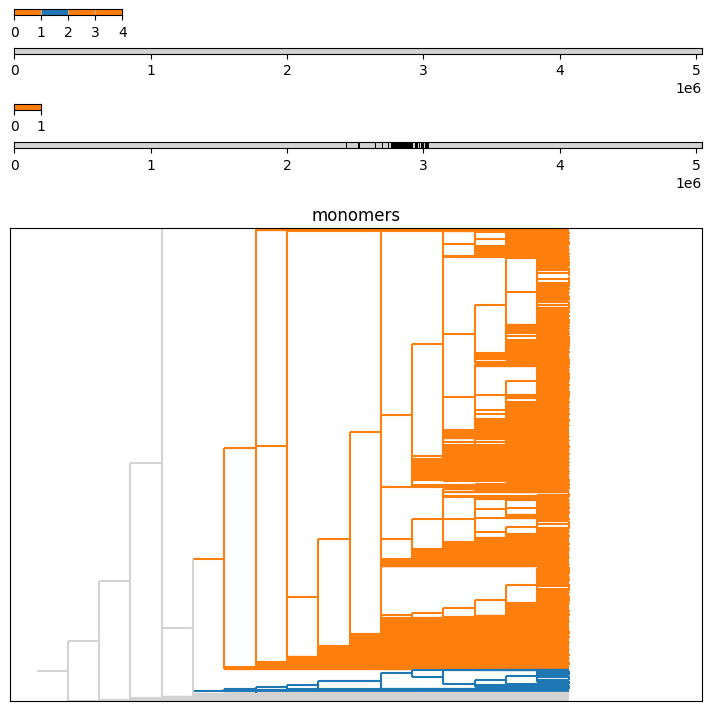

Subtree: [1, 1, 2, 1]
None


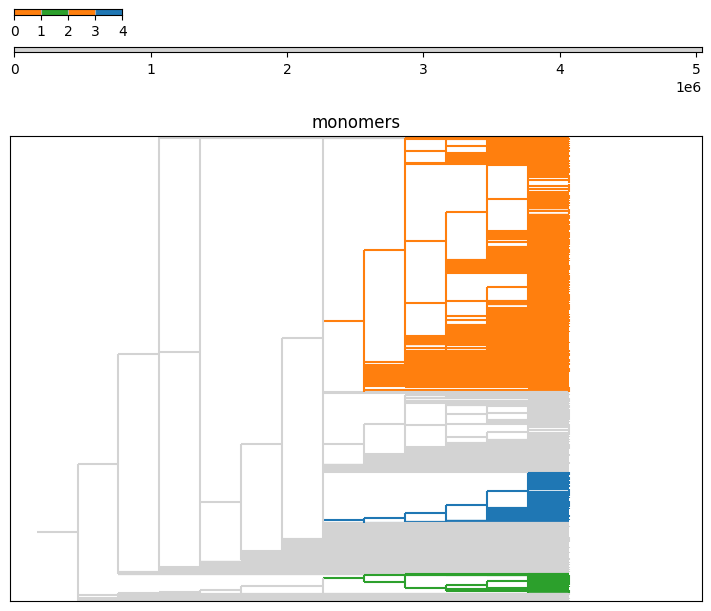

Subtree: [1, 1, 2, 2]
None


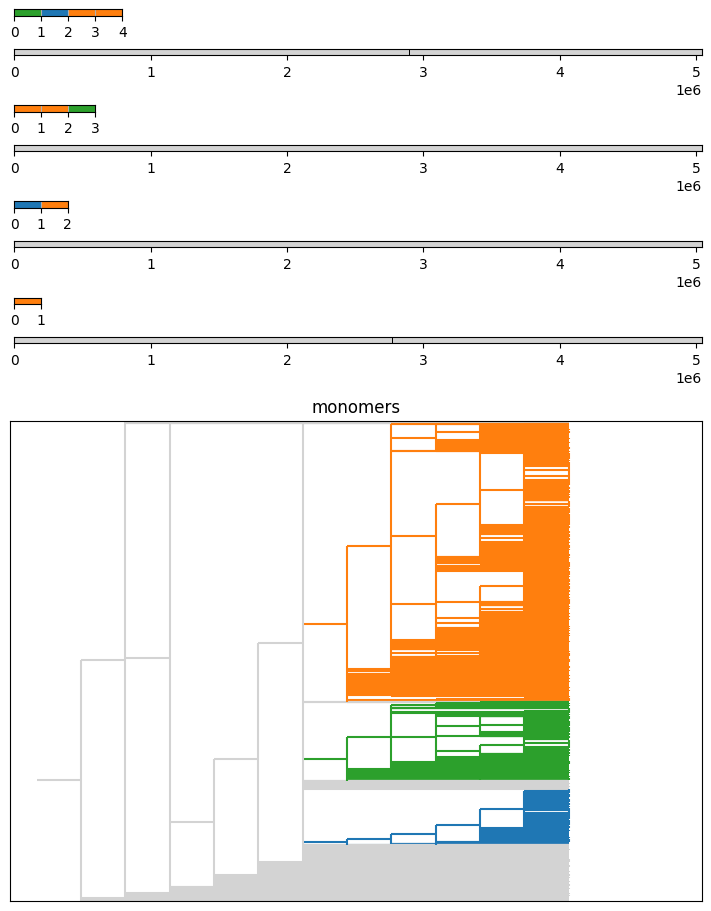

Subtree: [1, 2]
None


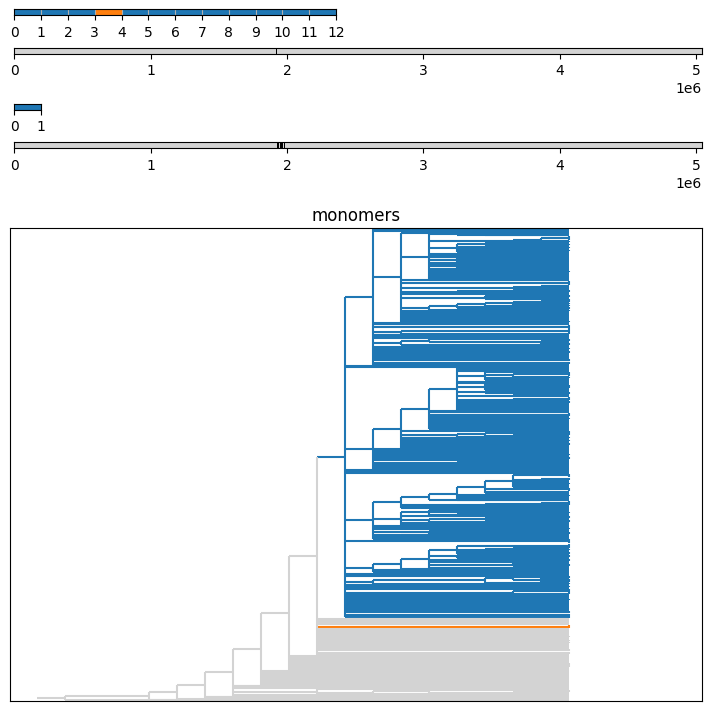

Subtree: [1, 2, 1]
None


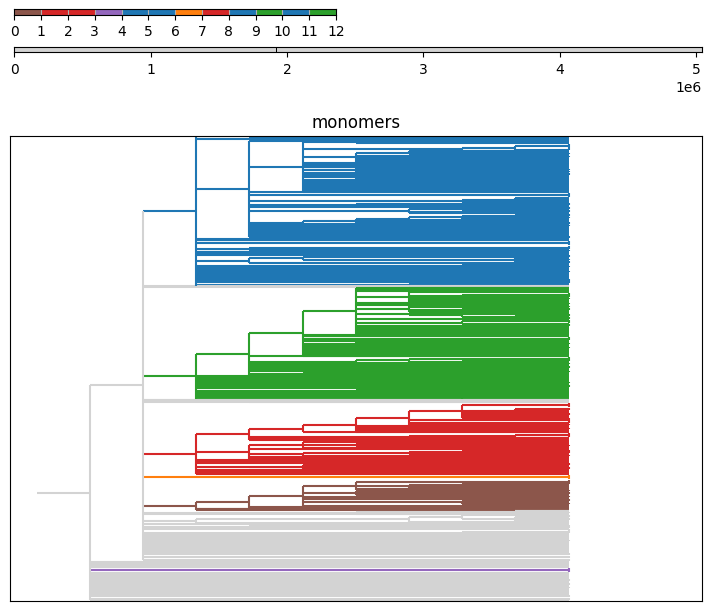

Subtree: [1, 2, 1, 1]
None


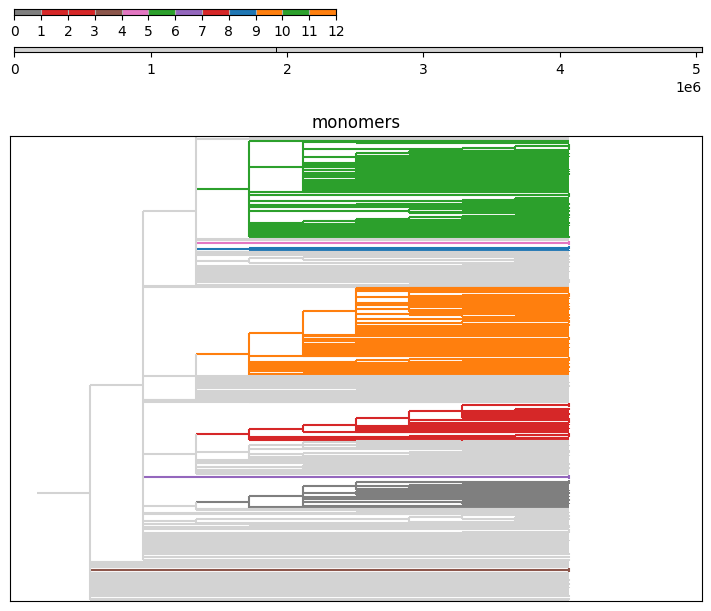

Subtree: [1, 2, 1, 1, 1]
None


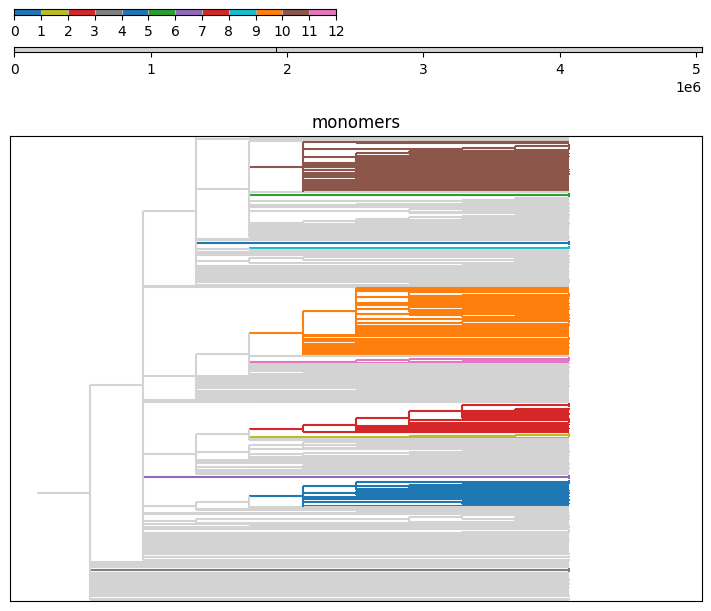

Subtree: [1, 2, 2]
None


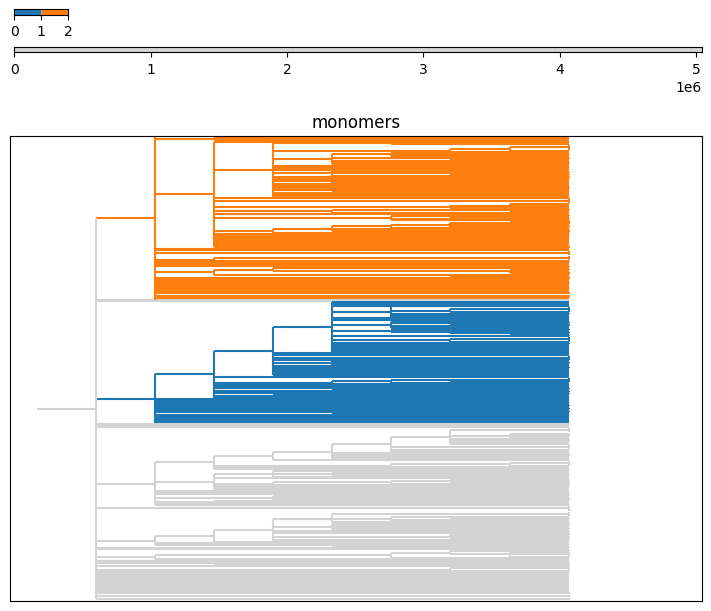

In [18]:
show_hor_tree(hor_tree_root, references['chr2:10940332-15983263'], phylogeny)

In [19]:
tree_output_filename = f'data/vitis/clusterings/test.tree.xml'
Phylo.write(phyloXml, tree_output_filename, format='phyloxml')

2